# CIFAR-10: Image Dataset

Throughout this course, we will teach you all basic skills and supply you with all neccessary tools that you need to implement deep neural networks, which is the main focus of this class. However, you should also be proficient with handling data and know how to prepare it for your specific task. In fact, most of the jobs that involve deep learning in industry are very data related so this is an important skill that you have to pick up.

Therefore, we we will take a deep dive into data preparation this week by implementing our own datasets and dataloader. In this notebook, we will focus on the image dataset CIFAR-10. The CIFAR-10 dataset consists of 50000 32x32 colour images in 10 classes, which are *plane*, *car*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*.

Let's start by importing some libraries that we will need along the way, as well as our code files that we will work on throughout this notebook.

In [1]:
import os
import pickle

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from exercise_code.data import (
    ImageFolderDataset,
    RescaleTransform,
    NormalizeTransform,
    ComposeTransform,
    compute_image_mean_and_std
)
from exercise_code.tests import (
    test_image_folder_dataset,
    test_rescale_transform,
    test_compute_image_mean_and_std,
    save_pickle
)

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Dataset Download
Let us get started by downloading our data. In `exercise_code/data/image_folder_dataset.py` you can find a class `ImageFolderDataset`, which you will have to complete throughout this notebook.

This class automatically downloads the raw data for you. To do so, simply initialize the class as below:

In [2]:
download_url = "https://cdn3.vision.in.tum.de/~dl4cv/cifar10.zip"
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
cifar_root = os.path.join(i2dl_exercises_path, "datasets", "cifar10")

In [3]:
dataset = ImageFolderDataset(
    root=cifar_root, 
    download_url=download_url
)

You should now be able to see the images in `i2dl_exercises/datasets/cifar10`, which should contain one subfolder per class, each containing the respective images labeled `0001.png`, `0002.png`, ...

By default, the dataset will only be downloaded the first time you initialize a dataset class. If, for some reason, your version of the dataset gets corrupted and you wish to redownload it, simply initialize the class with `force_download=True`, as shown below.

In [4]:
dataset = ImageFolderDataset(
    root=cifar_root,
    download_url=download_url,
    force_download=True
)

0it [00:00, ?it/s]

120725504it [00:29, 9173937.10it/s]                               

## Data Visualization

Before training any model you should *always* take a look at some samples of your dataset. This way you can make sure that the data input has worked as intended and you can get a feeling for the dataset. 

Let's load the CIFAR-10 data and visualize a subset of the images. To do so, we use `PIL.Image.open()` to open an image, and then `numpy.asarray()` to cast the image to an numpy array, which will have shape 32x32x3. We will load 7 images per class in this way, and then we use `matplotlib.pyplot` to visualize the images in a grid.

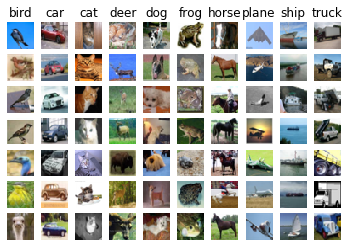

In [5]:
def load_image_as_numpy(image_path):
    return np.asarray(Image.open(image_path), dtype=float)

classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
]
num_classes = len(classes)
samples_per_class = 7
for label, cls in enumerate(sorted(classes)):
    for i in range(samples_per_class):
        image_path = os.path.join(cifar_root, cls, str(i+1).zfill(4) + ".png")  # e.g. cifar10/plane/0001.png
        image = np.asarray(Image.open(image_path))  # open image as numpy array
        plt_idx = i * num_classes + label + 1  # calculate plot location in the grid
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(image.astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)  # plot class names above columns
plt.show()

## TODO: ImageFolderDataset Implementation

Loading images as we have done above is a bit cumbersome. Therefore, we will now write a custom **Dataset** class, which takes care of the loading for us. This is always the first thing you have to implement when starting a new deep learning project.

The **Dataset** class is a wrapper that loads the data from a given filepath and returns a dictionary containing already prepared data, as we have done above. Datasets always need to have the following two methods implemented:
- `__len__(self)` is a method that should simply calculate and return the number of images in the dataset. After it is implemented, we can simply call it with `len(dataset)`.
- `__getitem(self, index)` should return the image with the given index from your dataset. Implementing this will allow you to access your dataset like a list, i.e. you can then simply call `dataset[9]` to access the 10th image in the dataset.

Now it is your turn to implement such a dataset class for CIFAR-10. To do so, open `exercise_code/data/image_folder_dataset.py` and implement the following three methods of `ImageFolderDataset`:
- `make_dataset(self, file_path)` should load the prepared data from a given file path into a dictionary.
- `__len__(self)` should calculate and return the number of images in your dataset.
- `__getitem(self, index)` should return the image with the given index from your dataset.

Once you're done, run the cells below to check if your implementation is correct.

**Hint:** You may want to reuse parts of the 'Data Visualization' code above in your implementation of `make_dataset()` and `__iter__()`.

In [6]:
dataset = ImageFolderDataset(
    root=cifar_root,
    download_url=download_url
)

In [7]:
test_image_folder_dataset(dataset)

MakeDatasetTestImageType passed.
Method make_dataset() correctly implemented. Tests passed: 1/1
LenTestInt passed.
LenTestCorrect passed.
Method __len__() correctly implemented. Tests passed: 2/2
GetItemTestType passed.
GetItemTestOrder passed.
GetItemTestImageShape passed.
Method __getitem__() correctly implemented. Tests passed: 3/3
Class ImageFolderDataset correctly implemented. Tests passed: 6/6
Score: 100/100


100

Using the `__getitem__()` method, you can now access your dataset conveniently:

In [8]:
print(dataset[0]["image"])
print(dataset[0]["label"])

[[[  3. 125. 233.]
  [  3. 130. 238.]
  [  4. 133. 241.]
  ...
  [  2. 128. 237.]
  [  3. 124. 233.]
  [  3. 119. 227.]]

 [[  2. 130. 239.]
  [  1. 136. 243.]
  [  3. 139. 244.]
  ...
  [  3. 134. 241.]
  [  4. 131. 238.]
  [  3. 127. 232.]]

 [[  4. 137. 244.]
  [  8. 140. 250.]
  [ 12. 145. 252.]
  ...
  [  5. 140. 245.]
  [  4. 138. 243.]
  [  5. 135. 241.]]

 ...

 [[ 52. 154. 252.]
  [ 53. 155. 255.]
  [ 55. 156. 254.]
  ...
  [ 70. 158. 255.]
  [ 70. 158. 254.]
  [ 68. 156. 249.]]

 [[ 50. 151. 251.]
  [ 53. 154. 254.]
  [ 55. 156. 253.]
  ...
  [ 70. 158. 255.]
  [ 68. 156. 254.]
  [ 64. 151. 250.]]

 [[ 45. 147. 252.]
  [ 50. 150. 253.]
  [ 53. 153. 251.]
  ...
  [ 64. 154. 250.]
  [ 60. 151. 249.]
  [ 55. 146. 248.]]]
0


And due to the `__len__()` and `__getitem__()` methods, you can even iterate over your dataset now! 

In [9]:
num_samples = 0
for sample in dataset:
    num_samples += 1
print("Number of samples:", num_samples)

Number of samples: 50000


## Image Preprocessing
Before training machine learning models, we often need to preprocess our data. For image datasets, two commonly applied techniques are:
1. Normalize all images so that each value is either in [-1, 1] or [0, 1]
2. Compute the mean image and substract it from all images in the dataset

Using your dataset class, you can now easily add those two preprocessing techniques for CIFAR-10, as we will do in the following by implementing the classes `RescaleTransform` and `NormalizeTransform` in `exercise_code/data/image_folder_dataset.py`.

These transform classes are callables, meaning that you will be able to simply use them as follows:

```transform = Transform()
images_transformed = transform(images)```

### TODO: Rescale Images to [0, 1] using RescaleTransform
Let's start by implementing `RescaleTransform`. If you look at the `__init__()` method you will notice it has four arguments:
* **range_** is the range you wish to rescale your images to. E.g. if you want to scale your images to [-1, 1], you would use `range=(-1, 1)`. By default, we will scale to [0, 1].
* **old_range** is the value range of the data prior to rescaling. For uint8 images, this will always be (0, 255).

Your task is now to complete the class by implementing the `__call__()` method that applies the transformation to a given set of images.

When you're done, run the following cells to test your implementation.

In [10]:
rescale_transform = RescaleTransform()

In [11]:
rescale_transform = RescaleTransform()
dataset_rescaled = ImageFolderDataset(
    root=cifar_root,
    download_url=download_url,
    transform=rescale_transform
)

In [12]:
len(dataset_rescaled[0]['image'])

32

In [13]:
test_rescale_transform(dataset_rescaled)

RescaleTransformTestMin passed.
RescaleTransformTestMax passed.
Class RescaleTransform correctly implemented. Tests passed: 2/2
Score: 100/100


100

If you look at the first image, you should now see that all values are between 0 and 1.

### Normalize Images to Standard Gaussian using NormalizeTransform
Let us now move on to the `NormalizeTransform` class. The `NormalizeTransform` class normalizes images channel-wise and it's `__init__` method has two arguments:
* **mean** is the normalization mean, which we substract from the dataset.
* **std** is the normalization standard deviation. By scaling our data with a factor of `1/std` we will normalize the standard deviation accordingly.

Have a look at the code in `exercise_code/data/image_folder_dataset.py`.

What we would like to do now is to normalize our CIFAR-10 images channel-wise to standard normal. To do so, we need to calculate the per-channel image mean and standard deviation first, which we can then provide to `NormalizeTransform` to normalize our data accordingly.

Calculating the per-channel image mean and standard deviation is your task. To do so, implement `compute_image_mean_and_std()` in `exercise_code/data/image_folder_dataset.py` and run the cell below.

In [44]:
rescaled_images = []
for sample in dataset_rescaled:
    rescaled_images.append(sample["image"])
rescaled_images = np.array(rescaled_images)
cifar_mean, cifar_std = compute_image_mean_and_std(rescaled_images)
print("Mean:\t", cifar_mean, "\nStd:\t", cifar_std)

Mean:	 [0.49191375 0.48235852 0.44673872] 
Std:	 [0.00088138 0.00114629 0.00052645]


To test your implementation, run the following line:

In [45]:
test_compute_image_mean_and_std(cifar_mean, cifar_std)

CIFARImageMeanTest passed.
CIFARImageStdTest passed.
Method compute_image_mean_and_std() correctly implemented. Tests passed: 2/2
Score: 100/100


100

Now we can use the mean and standard deviation you computed to normalize the data we load, simply by adding the `NormalizeTransform` to the list of transformation our dataset applies in `__getitem__()`.

In [46]:
rescale_transform = RescaleTransform()
normalize_transform = NormalizeTransform(
    mean=cifar_mean,
    std=cifar_std
)
dataset = ImageFolderDataset(
    root=cifar_root,
    download_url=download_url,
    transform=ComposeTransform([rescale_transform, normalize_transform])
)

In [47]:
print(dataset[0]["image"])

[[[-544.77114764    6.83731683  887.0498746 ]
  [-544.77114764   23.94276831  924.2953297 ]
  [-540.32178453   34.2060392   946.64260276]
  ...
  [-549.22051074   17.10058772  916.84623868]
  [-544.77114764    3.41622653  887.0498746 ]
  [-544.77114764  -13.68922494  842.35532847]]

 [[-549.22051074   23.94276831  931.74442072]
  [-553.66987384   44.46931008  961.5407848 ]
  [-544.77114764   54.73258097  968.98987582]
  ...
  [-544.77114764   37.62712949  946.64260276]
  [-540.32178453   27.36385861  924.2953297 ]
  [-544.77114764   13.67949742  879.60078357]]

 [[-540.32178453   47.89040038  968.98987582]
  [-522.52433212   58.15367127 1013.68442195]
  [-504.72687971   75.25912275 1028.58260399]
  ...
  [-535.87242143   58.15367127  976.43896685]
  [-540.32178453   51.31149068  961.5407848 ]
  [-535.87242143   41.04821979  946.64260276]]

 ...

 [[-326.75235557  106.04893541 1028.58260399]
  [-322.30299247  109.4700257  1050.92987705]
  [-313.40426626  112.891116   1043.48078603]
  ..

### Save your DataLoaders for Submission
Now save your dataset and transforms using the following cell. This will save it to a pickle file `models/cifar_dataset.p`.

In [48]:
save_pickle(
    data_dict={
        "dataset": dataset_rescaled,
        "cifar_mean": cifar_mean,
        "cifar_std": cifar_std,
    },
    file_name="cifar_dataset.p"
)

## Key Takeaways
1. Always have a look at your data before you start training any models on it.
2. Datasets should be organized in corresponding **Dataset** classes that support `__len__` and `__getitem__` methods, which allows us to call `len(dataset)` and `dataset[index]`.
3. Data often needs to be preprocessed; such preprocessing can be implemented in **Transform** classes, which are callables that can be simply applied via `data_transformed = transform(data)`.

# Submission Instructions

Now, that you have completed the neccessary parts in the notebook, you can go on and submit your files.

1. Go on [our submission page](https://dvl.in.tum.de/teaching/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum online and check your mails there. You will get an id which we need in the next step.
2. Navigate to `exercise_code` directory and run the `create_submission.sh` file to create the zip file of your model. This will create a single `zip` file that you need to upload. Otherwise, you can also zip it manually if you don't want to use the bash script.
3. Log into [our submission page](https://dvl.in.tum.de/teaching/submission/) with your account details and upload the `zip` file. Once successfully uploaded, you should be able to see the submitted "dummy_model.p" file selectable on the top.
4. Click on this file and run the submission script. You will get an email with your score as well as a message if you have surpassed the threshold.

<img src="./images/i2dlsubmission.png">

# Submission Goals

- Goal: Implement an ImageFolderDataset with transforms for rescaling and normalizing.
- To implement: 
    1. `exercise_code/data/image_folder_dataset.py`: `ImageFolderDataset` - `make_dataset()`, `__len__()`, `__getitem()__`
    2. `exercise_code/data/image_folder_dataset.py`: `RescaleTransform`
    3. `exercise_code/data/image_folder_dataset.py`: `compute_image_mean_and_std()`
- Test cases:
  1. Does `make_dataset()` of `ImageFolderDataset` load paths to images only (and not the actual images)?
  2. Does `__len__()` of `ImageFolderDataset` return the correct data type?
  3. Does `__len__()` of `ImageFolderDataset` return the correct value?
  4. Does `__getitem()__` of `ImageFolderDataset` return the correct data type?
  5. Does `__getitem()__` of `ImageFolderDataset` load images as numpy arrays with correct shape?
  6. Does `__getitem()__` of `ImageFolderDataset` return the data in the correct order?
  7. Do values after rescaling with `RescaleTransform` have the correct minimum?
  8. Do values after rescaling with `RescaleTransform` have the correct maximum?
  9. Does `compute_image_mean_and_std()` compute the correct mean?
  10. Does `compute_image_mean_and_std()` compute the correct std?
- Reachable points [0, 100]: 0 if not implemented, 100 if all tests passed, 10 per passed test
- Threshold to clear exercise: 80
- Submission start: __May 11, 2020 23.59__
- Submission deadline : __May 17, 2020 23.59__. 
- You can make multiple submission uptil the deadline. Your __best submission__ will be considered for bonus